# Tâche 3 : Détection de Fraude dans les Documents d'Identité

Ce notebook a pour objectif de résoudre la troisième tâche du challenge ANIP : détecter les fraudes et falsifications dans les documents d'identité officiels.

## Objectif

Développer une IA capable de distinguer automatiquement les documents authentiques des documents falsifiés avec la meilleure précision possible.

## Types de Documents Analysés

Le dataset contient plusieurs types de documents d'identité :
- **Arizona DL** : Permis de conduire d'Arizona (États-Unis)
- **ESP** : Documents espagnols
- **EST** : Documents estoniens
- **RUS** : Documents russes

## Classes de Falsification

Pour chaque type de document, nous devons classifier :
- **Normal** : Documents authentiques
- **Forgery 1-4** : Différents types de falsifications

## Stratégie Adoptée

Notre approche sera systématique et basée sur les meilleures pratiques de détection de fraude :

1. **Analyse Exploratoire des Données** : Comprendre la distribution des classes, types de documents, et qualité des images
2. **Préparation des Données** : Organisation par type de document et classe, normalisation, augmentation
3. **Extraction de Caractéristiques** : Techniques de vision par ordinateur et analyse d'images
4. **Modélisation** : Classification multi-classe avec Deep Learning et techniques spécialisées
5. **Évaluation** : Métriques de précision, rappel, F1-score par classe et type de document
6. **Prédiction Finale** : Application sur les données de test et génération de la soumission

In [ ]:
# Importation des bibliothèques fondamentales
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
print("Bibliothèques de base importées.")

In [43]:
# Installation des packages nécessaires
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installé avec succès")
    except subprocess.CalledProcessError:
        print(f"✗ Erreur lors de l'installation de {package}")

print("Installation des packages nécessaires...")

# Packages essentiels pour PyTorch et OCR
packages = [
    "torch",
    "torchvision", 
    "scikit-learn",
    "pytesseract",
    "easyocr"
]

for package in packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} déjà installé")
    except ImportError:
        print(f"Installation de {package}...")
        install_package(package)

print("Installation terminée.")

Installation des packages nécessaires...
✓ torch déjà installé
✓ torchvision déjà installé
Installation de scikit-learn...
✓ scikit-learn installé avec succès
✓ pytesseract déjà installé
✓ easyocr déjà installé
Installation terminée.
✓ scikit-learn installé avec succès
✓ pytesseract déjà installé
✓ easyocr déjà installé
Installation terminée.


## 1. Configuration de l'Environnement

Définition des chemins et exploration de la structure des données pour la détection de fraude documentaire.

In [2]:
# Configuration des chemins de données
from pathlib import Path
import os

# Configuration pour l'environnement local
DATA_ROOT = Path('/kaggle/input/tache3-anip/dataset_tache_3/dataset_tache_3')
TRAIN_DIR = DATA_ROOT / 'train'
TEST_DIR = DATA_ROOT / 'test'  # Données de test (si disponibles)
# SUBMISSIONS_DIR = Path('/workspaces/anip-facial-ocr-challenge/submissions')

print("Configuration des chemins:")
print(f"   Dataset root: {DATA_ROOT}")
print(f"   Train directory: {TRAIN_DIR}")
print(f"   Test directory: {TEST_DIR}")
# print(f"   Submissions: {SUBMISSIONS_DIR}")

# Vérification des chemins
train_exists = TRAIN_DIR.exists()
test_exists = TEST_DIR.exists()

print(f"\nVérification:")
print(f"   Train folder: {'OK' if train_exists else 'MANQUANT'} {TRAIN_DIR}")
print(f"   Test folder: {'OK' if test_exists else 'MANQUANT'} {TEST_DIR}")

# Exploration de la structure des données d'entraînement
if train_exists:
    document_types = [d.name for d in TRAIN_DIR.iterdir() if d.is_dir()]
    print(f"\nTypes de documents trouvés: {document_types}")
    
    # Pour chaque type de document, explorer les classes
    for doc_type in document_types:
        doc_path = TRAIN_DIR / doc_type
        classes = [c.name for c in doc_path.iterdir() if c.is_dir()]
        print(f"   {doc_type}: {classes}")
        
        # Compter les images dans chaque classe
        for class_name in classes:
            class_path = doc_path / class_name
            image_files = list(class_path.glob('*.png')) + list(class_path.glob('*.jpg')) + list(class_path.glob('*.jpeg'))
            print(f"      {class_name}: {len(image_files)} images")
else:
    print("   ATTENTION: Les données d'entraînement ne sont pas disponibles")
    document_types = []

# Exploration des données de test (si disponibles)
if test_exists:
    print(f"\nExploration des données de test:")
    test_structure = [item.name for item in TEST_DIR.iterdir()]
    print(f"   Structure: {test_structure}")
else:
    print("\n   Les données de test ne sont pas encore disponibles localement")

Configuration des chemins:
   Dataset root: /kaggle/input/tache3-anip/dataset_tache_3/dataset_tache_3
   Train directory: /kaggle/input/tache3-anip/dataset_tache_3/dataset_tache_3/train
   Test directory: /kaggle/input/tache3-anip/dataset_tache_3/dataset_tache_3/test

Vérification:
   Train folder: OK /kaggle/input/tache3-anip/dataset_tache_3/dataset_tache_3/train
   Test folder: OK /kaggle/input/tache3-anip/dataset_tache_3/dataset_tache_3/test

Types de documents trouvés: ['rus', 'est', 'arizona_dl', 'esp']
   rus: ['forgery_1', 'normal', 'gt', 'forgery_2', 'forgery_4', 'forgery_3']
      forgery_1: 500 images
      normal: 500 images
      gt: 0 images
      forgery_2: 500 images
      forgery_4: 500 images
      forgery_3: 500 images
   est: ['forgery_1', 'normal', 'gt', 'forgery_2', 'forgery_4', 'forgery_3']
      forgery_1: 500 images
      normal: 500 images
      gt: 0 images
      forgery_2: 500 images
      forgery_4: 500 images
      forgery_3: 500 images
   arizona_dl: ['for

## 2. Analyse Exploratoire des Données (AED)

### 2.1 Collecte et Structuration des Métadonnées

Nous allons analyser la distribution des documents par type et catégorie (authentique vs falsifié).

In [4]:
# Construction du dataset principal
print("CONSTRUCTION DU DATASET")
print("="*50)

data_list = []

if train_exists and document_types:
    for doc_type in document_types:
        doc_path = TRAIN_DIR / doc_type
        
        if not doc_path.exists():
            continue
            
        classes = [c.name for c in doc_path.iterdir() if c.is_dir()]
        
        for class_name in classes:
            class_path = doc_path / class_name
            
            # Recherche des images avec extensions robustes
            image_files = []
            for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG', '*.JPEG']:
                image_files.extend(list(class_path.glob(ext)))
            
            for img_path in image_files:
                data_list.append({
                    'file_path': str(img_path),
                    'filename': img_path.name,
                    'document_type': doc_type,
                    'class_name': class_name,
                    'is_authentic': 1 if class_name == 'normal' else 0,
                    'forgery_type': class_name if class_name != 'normal' else 'authentic'
                })

    # Créer le DataFrame principal
    df_train = pd.DataFrame(data_list)
    
    print(f"Dataset construit avec succès:")
    print(f"   Total images: {len(df_train)}")
    print(f"   Types de documents: {df_train['document_type'].nunique()}")
    print(f"   Classes: {df_train['class_name'].nunique()}")
    
    if len(df_train) > 0:
        print("\nAperçu des données:")
        print(df_train.head())
        
        print("\nDistribution par type de document:")
        print(df_train['document_type'].value_counts())
        
        print("\nDistribution par classe:")
        print(df_train['class_name'].value_counts())
        
        print("\nDistribution authentique vs falsifié:")
        print(df_train['is_authentic'].value_counts())
        
else:
    print("ATTENTION: Impossible de construire le dataset - données manquantes")
    df_train = pd.DataFrame()

# Informations sur le dataset
if len(df_train) > 0:
    print(f"\nInformations détaillées:")
    print(df_train.info())

CONSTRUCTION DU DATASET
Dataset construit avec succès:
   Total images: 10000
   Types de documents: 4
   Classes: 5

Aperçu des données:
                                           file_path  \
0  /kaggle/input/tache3-anip/dataset_tache_3/data...   
1  /kaggle/input/tache3-anip/dataset_tache_3/data...   
2  /kaggle/input/tache3-anip/dataset_tache_3/data...   
3  /kaggle/input/tache3-anip/dataset_tache_3/data...   
4  /kaggle/input/tache3-anip/dataset_tache_3/data...   

                          filename document_type class_name  is_authentic  \
0  generated.photos_v3_0061426.png           rus  forgery_1             0   
1  generated.photos_v3_0053668.png           rus  forgery_1             0   
2  generated.photos_v3_0052096.png           rus  forgery_1             0   
3  generated.photos_v3_0008043.png           rus  forgery_1             0   
4  generated.photos_v3_0049824.png           rus  forgery_1             0   

  forgery_type  
0    forgery_1  
1    forgery_1  
2    forger

## 3. Analyse des Fichiers Ground Truth (GT) pour l'OCR

### Objectif

Les fichiers GT contiennent les annotations OCR de référence pour chaque document. Cette analyse nous permet de :

1. **Comprendre la structure des données de sortie** attendues pour la soumission
2. **Identifier les champs OCR communs** à tous les types de documents
3. **Détecter les champs spécifiques** à chaque pays/type de document
4. **Préparer le format de prédiction** pour les données de test

### Champs OCR attendus

D'après les exemples que nous avons vus :
- **Champs d'identité** : `surname`, `given_name`, `birthday`, `gender`
- **Champs de document** : `country_code`, `issue_date`, `expire_date`, `card_num`, `personal_num`
- **Champs spécifiques** : `second_surname` (ESP), `place_of_birth` (EST), etc.

In [39]:
import json

# Analyse des fichiers Ground Truth (GT) pour comprendre la structure OCR
print("ANALYSE DES FICHIERS GROUND TRUTH (GT)")
print("="*45)

gt_data = []
all_fields = set()
field_by_document = {}

if train_exists and document_types:
    for doc_type in document_types:
        gt_path = TRAIN_DIR / doc_type / 'gt'
        
        if gt_path.exists():
            # Rechercher les fichiers JSON
            json_files = list(gt_path.glob('*.json'))
            
            print(f"\n--- {doc_type.upper()} ---")
            print(f"Fichiers GT trouvés: {len(json_files)}")
            
            # Analyser les premiers fichiers pour comprendre la structure
            sample_files = json_files[:5]  # Analyser 5 fichiers par type
            
            for json_file in sample_files:
                try:
                    with open(json_file, 'r', encoding='utf-8') as f:
                        gt_content = json.load(f)
                    
                    # Stocker pour analyse globale
                    gt_data.append({
                        'document_type': doc_type,
                        'filename': json_file.name,
                        'gt_content': gt_content
                    })
                    
                    # Collecter tous les champs
                    for field in gt_content.keys():
                        all_fields.add(field)
                        
                        if doc_type not in field_by_document:
                            field_by_document[doc_type] = set()
                        field_by_document[doc_type].add(field)
                    
                    # Afficher un exemple
                    if json_file == sample_files[0]:  # Premier fichier seulement
                        print(f"\nExemple GT ({json_file.name}):")
                        for key, value in gt_content.items():
                            print(f"   {key}: '{value}'")
                            
                except Exception as e:
                    print(f"Erreur lecture {json_file.name}: {e}")

    print(f"\nRÉSUMÉ DE L'ANALYSE:")
    print(f"Total champs OCR identifiés: {len(all_fields)}")
    print(f"Champs: {sorted(all_fields)}")
    
    # Identifier les champs communs à tous les types de documents
    if len(field_by_document) > 1:
        common_fields = set.intersection(*field_by_document.values())
        print(f"\nChamps communs à tous les documents: {sorted(common_fields)}")
        
        # Champs spécifiques par type
        print(f"\nChamps spécifiques par type:")
        for doc_type, fields in field_by_document.items():
            specific = fields - common_fields
            if specific:
                print(f"   {doc_type}: {sorted(specific)}")
    
else:
    print("Impossible d'analyser les fichiers GT - données manquantes")

ANALYSE DES FICHIERS GROUND TRUTH (GT)

--- RUS ---
Fichiers GT trouvés: 500

Exemple GT (generated.photos_v3_0067921.json):
   country_code: 'RUS'
   surname: 'ЮРИЙ'
   given_name: 'СМИРНОВ'
   birthday: '04.09.1996'
   issue_date: '20.01.2021'
   expire_date: '20.01.2031'
   gender: 'МУЖ'
   patronymic_name: 'АНДРЕЕВИЧ'
   place_of_birth: 'УФА'
   card_num: '73 42 038028'

--- EST ---
Fichiers GT trouvés: 500

Exemple GT (generated.photos_v3_0067921.json):
   type: 'P'
   country_code: 'EST'
   country: 'EST'
   surname: 'Taavi'
   given_name: 'KUUSIK'
   birthday: '12.08.1996'
   gender: 'M/M'
   issue_date: '30.07.2021'
   expire_date: '30.07.2031'
   place_of_birth: 'EST'
   issue_authority: 'PPA/PBGB'
   personal_num: '42698336660'
   card_num: 'OX1685383'

--- ARIZONA_DL ---
Fichiers GT trouvés: 500

Exemple GT (generated.photos_v3_0157489.json):
   name: 'Michael Anderson'
   address: '258 Ash Ave, Oro Valley, AZ 85755'
   birthday: '03/18/1987'
   gender: 'M'
   class: 'D'
   

## 4. Analyse des Propriétés des Images

### Objectifs de cette analyse

1. **Dimensions et formats** : Comprendre la variabilité des tailles d'images pour le preprocessing
2. **Qualité et résolution** : Évaluer la qualité des images pour l'OCR
3. **Cohérence par type** : Vérifier si chaque type de document a des caractéristiques communes
4. **Preprocessing nécessaire** : Définir les transformations à appliquer

### Importance pour l'OCR

- **Résolution** : Une résolution insuffisante peut compromettre la lecture des textes
- **Dimensions** : Nécessaire pour définir la taille d'entrée des modèles
- **Format** : RGB vs Grayscale peut affecter les performances OCR

In [41]:
if len(df_train) > 0:
    print("ANALYSE DES PROPRIÉTÉS DES IMAGES")
    print("="*40)
    
    # Échantillonner pour l'analyse (pour éviter de traiter toutes les images)
    sample_size = min(100, len(df_train))
    sample_df = df_train.sample(n=sample_size, random_state=42)
    
    image_properties = []
    
    print(f"Analyse d'un échantillon de {sample_size} images...")
    
    for idx, row in sample_df.iterrows():
        try:
            img_path = Path(row['file_path'])
            
            # Lire l'image
            img = Image.open(img_path)
            img_array = np.array(img)
            
            # Calculer les propriétés
            file_size = img_path.stat().st_size / (1024*1024)  # Taille en MB
            
            properties = {
                'document_type': row['document_type'],
                'class_name': row['class_name'],
                'width': img.width,
                'height': img.height,
                'channels': len(img_array.shape),
                'mode': img.mode,
                'file_size_mb': file_size,
                'aspect_ratio': img.width / img.height,
                'total_pixels': img.width * img.height
            }
            
            # Statistiques de luminosité
            if len(img_array.shape) == 3:  # Image couleur
                gray = np.mean(img_array, axis=2)
                properties['mean_brightness'] = np.mean(gray)
                properties['std_brightness'] = np.std(gray)
            else:  # Image grayscale
                properties['mean_brightness'] = np.mean(img_array)
                properties['std_brightness'] = np.std(img_array)
            
            image_properties.append(properties)
            
        except Exception as e:
            print(f"Erreur analyse {row['filename']}: {e}")
    
    # Créer DataFrame des propriétés
    props_df = pd.DataFrame(image_properties)
    
    if len(props_df) > 0:
        print(f"\nImages analysées avec succès: {len(props_df)}")
        
        # Statistiques globales
        print(f"\nSTATISTIQUES GLOBALES:")
        print(f"   Largeur - Min: {props_df['width'].min()}, Max: {props_df['width'].max()}, Moyenne: {props_df['width'].mean():.0f}")
        print(f"   Hauteur - Min: {props_df['height'].min()}, Max: {props_df['height'].max()}, Moyenne: {props_df['height'].mean():.0f}")
        print(f"   Ratio aspect - Min: {props_df['aspect_ratio'].min():.2f}, Max: {props_df['aspect_ratio'].max():.2f}")
        print(f"   Taille fichier - Min: {props_df['file_size_mb'].min():.2f}MB, Max: {props_df['file_size_mb'].max():.2f}MB")
        
        # Modes d'image
        print(f"\nMODES D'IMAGE:")
        mode_counts = props_df['mode'].value_counts()
        for mode, count in mode_counts.items():
            percentage = count / len(props_df) * 100
            print(f"   {mode}: {count} images ({percentage:.1f}%)")
        
        # Analyse par type de document
        print(f"\nANALYSE PAR TYPE DE DOCUMENT:")
        for doc_type in props_df['document_type'].unique():
            doc_props = props_df[props_df['document_type'] == doc_type]
            print(f"\n   --- {doc_type.upper()} ---")
            print(f"   Dimensions moyennes: {doc_props['width'].mean():.0f} x {doc_props['height'].mean():.0f}")
            print(f"   Luminosité moyenne: {doc_props['mean_brightness'].mean():.1f}")
            print(f"   Taille moyenne: {doc_props['file_size_mb'].mean():.2f}MB")
    
    else:
        print("Aucune image analysée avec succès")
        
else:
    print("Pas de données pour analyser les images")

ANALYSE DES PROPRIÉTÉS DES IMAGES
Analyse d'un échantillon de 100 images...



Images analysées avec succès: 100

STATISTIQUES GLOBALES:
   Largeur - Min: 600, Max: 1519, Moyenne: 1091
   Hauteur - Min: 375, Max: 1069, Moyenne: 706
   Ratio aspect - Min: 1.42, Max: 1.60
   Taille fichier - Min: 0.07MB, Max: 0.41MB

MODES D'IMAGE:
   RGB: 100 images (100.0%)

ANALYSE PAR TYPE DE DOCUMENT:

   --- ARIZONA_DL ---
   Dimensions moyennes: 600 x 375
   Luminosité moyenne: 169.1
   Taille moyenne: 0.41MB

   --- EST ---
   Dimensions moyennes: 929 x 580
   Luminosité moyenne: 195.7
   Taille moyenne: 0.07MB

   --- RUS ---
   Dimensions moyennes: 1519 x 1069
   Luminosité moyenne: 213.0
   Taille moyenne: 0.19MB

   --- ESP ---
   Dimensions moyennes: 1327 x 827
   Luminosité moyenne: 175.1
   Taille moyenne: 0.17MB


## 5. Préparation du Split Train/Validation

### Train/Validation Split Stratifié

Nous devons créer un split intelligent qui préserve :
- La distribution des types de documents
- La distribution des classes (normal vs forgery_X) 
- La représentativité de chaque pays

Cette étape est cruciale pour s'assurer que notre modèle sera évalué de manière équitable.

In [42]:
if len(df_train) > 0:
    print("CRÉATION DU SPLIT TRAIN/VALIDATION STRATIFIÉ")
    print("="*50)
    
    # Créer une stratification combinée document_type + class_name
    df_train['stratify_key'] = df_train['document_type'] + '_' + df_train['class_name']
    
    print("Groupes de stratification:")
    stratify_counts = df_train['stratify_key'].value_counts()
    for group, count in stratify_counts.items():
        print(f"   {group}: {count} images")
    
    # Vérifier qu'aucun groupe n'a moins de 2 échantillons (nécessaire pour le split)
    min_samples = stratify_counts.min()
    if min_samples < 2:
        print(f"\nATTENTION: Certains groupes ont moins de 2 échantillons (min: {min_samples})")
        print("Utilisation d'une stratification simplifiée par document_type seulement")
        stratify_column = df_train['document_type']
    else:
        stratify_column = df_train['stratify_key']
    
    # Split 80/20 avec stratification
    X = df_train[['file_path', 'filename', 'document_type', 'class_name', 'is_authentic', 'forgery_type']]
    y = df_train['is_authentic']  # Target principal: authentique vs falsifié
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=stratify_column
    )
    
    print(f"\nSplit réalisé:")
    print(f"   Train: {len(X_train)} images ({len(X_train)/len(df_train)*100:.1f}%)")
    print(f"   Validation: {len(X_val)} images ({len(X_val)/len(df_train)*100:.1f}%)")
    
    # Vérifier la distribution dans chaque ensemble
    print(f"\nDistribution par type de document:")
    print("TRAIN:")
    train_doc_dist = X_train['document_type'].value_counts(normalize=True) * 100
    for doc_type, pct in train_doc_dist.items():
        print(f"   {doc_type}: {pct:.1f}%")
    
    print("VALIDATION:")
    val_doc_dist = X_val['document_type'].value_counts(normalize=True) * 100
    for doc_type, pct in val_doc_dist.items():
        print(f"   {doc_type}: {pct:.1f}%")
    
    print(f"\nDistribution authentique/falsifié:")
    print(f"TRAIN - Authentiques: {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")
    print(f"TRAIN - Falsifiés: {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%)")
    print(f"VAL - Authentiques: {(y_val==1).sum()} ({(y_val==1).mean()*100:.1f}%)")
    print(f"VAL - Falsifiés: {(y_val==0).sum()} ({(y_val==0).mean()*100:.1f}%)")
    
else:
    print("Pas de données pour créer le split")
    X_train, X_val, y_train, y_val = None, None, None, None

CRÉATION DU SPLIT TRAIN/VALIDATION STRATIFIÉ
Groupes de stratification:
   rus_forgery_1: 500 images
   rus_normal: 500 images
   esp_forgery_4: 500 images
   esp_forgery_2: 500 images
   esp_normal: 500 images
   esp_forgery_1: 500 images
   arizona_dl_forgery_3: 500 images
   arizona_dl_forgery_4: 500 images
   arizona_dl_forgery_2: 500 images
   arizona_dl_normal: 500 images
   arizona_dl_forgery_1: 500 images
   est_forgery_3: 500 images
   est_forgery_4: 500 images
   est_forgery_2: 500 images
   est_normal: 500 images
   est_forgery_1: 500 images
   rus_forgery_3: 500 images
   rus_forgery_4: 500 images
   rus_forgery_2: 500 images
   esp_forgery_3: 500 images

Split réalisé:
   Train: 8000 images (80.0%)
   Validation: 2000 images (20.0%)

Distribution par type de document:
TRAIN:
   est: 25.0%
   arizona_dl: 25.0%
   rus: 25.0%
   esp: 25.0%
VALIDATION:
   arizona_dl: 25.0%
   rus: 25.0%
   est: 25.0%
   esp: 25.0%

Distribution authentique/falsifié:
TRAIN - Authentiques: 1600 

## 6. Visualisation d'Exemples d'Images par Type et Classe

### Objectifs

1. **Inspection visuelle** : Comprendre les différences entre documents authentiques et falsifiés
2. **Qualité OCR** : Évaluer la lisibilité des textes dans les documents
3. **Patterns de falsification** : Identifier les caractéristiques visuelles des différents types de fraude
4. **Preprocessing** : Définir les techniques de nettoyage et amélioration d'image nécessaires

### Ce qu'il faut observer

- **Netteté du texte** : Les documents falsifiés peuvent avoir des textes flous ou pixélisés
- **Cohérence des polices** : Les falsifications peuvent mélanger différentes polices
- **Alignement** : Les informations peuvent être mal alignées dans les falsifications
- **Qualité d'impression** : Différences de qualité entre authentiques et falsifiés

VISUALISATION D'EXEMPLES D'IMAGES

--- Exemples pour ARIZONA_DL ---
   forgery_1: generated.photos_v3_0144032.png
   forgery_2: generated.photos_v3_0144032.png
   forgery_3: generated.photos_v3_0144032.png
   forgery_4: generated.photos_v3_0144032.png
   normal: generated.photos_v3_0144032.png

--- Exemples pour ESP ---
   forgery_1: generated.photos_v3_0061426.png
   forgery_2: generated.photos_v3_0061426.png

--- Exemples pour ARIZONA_DL ---
   forgery_1: generated.photos_v3_0144032.png
   forgery_2: generated.photos_v3_0144032.png
   forgery_3: generated.photos_v3_0144032.png
   forgery_4: generated.photos_v3_0144032.png
   normal: generated.photos_v3_0144032.png

--- Exemples pour ESP ---
   forgery_1: generated.photos_v3_0061426.png
   forgery_2: generated.photos_v3_0061426.png
   forgery_3: generated.photos_v3_0061426.png
   forgery_4: generated.photos_v3_0061426.png
   normal: generated.photos_v3_0061426.png

--- Exemples pour EST ---
   forgery_1: generated.photos_v3_0061426.pn

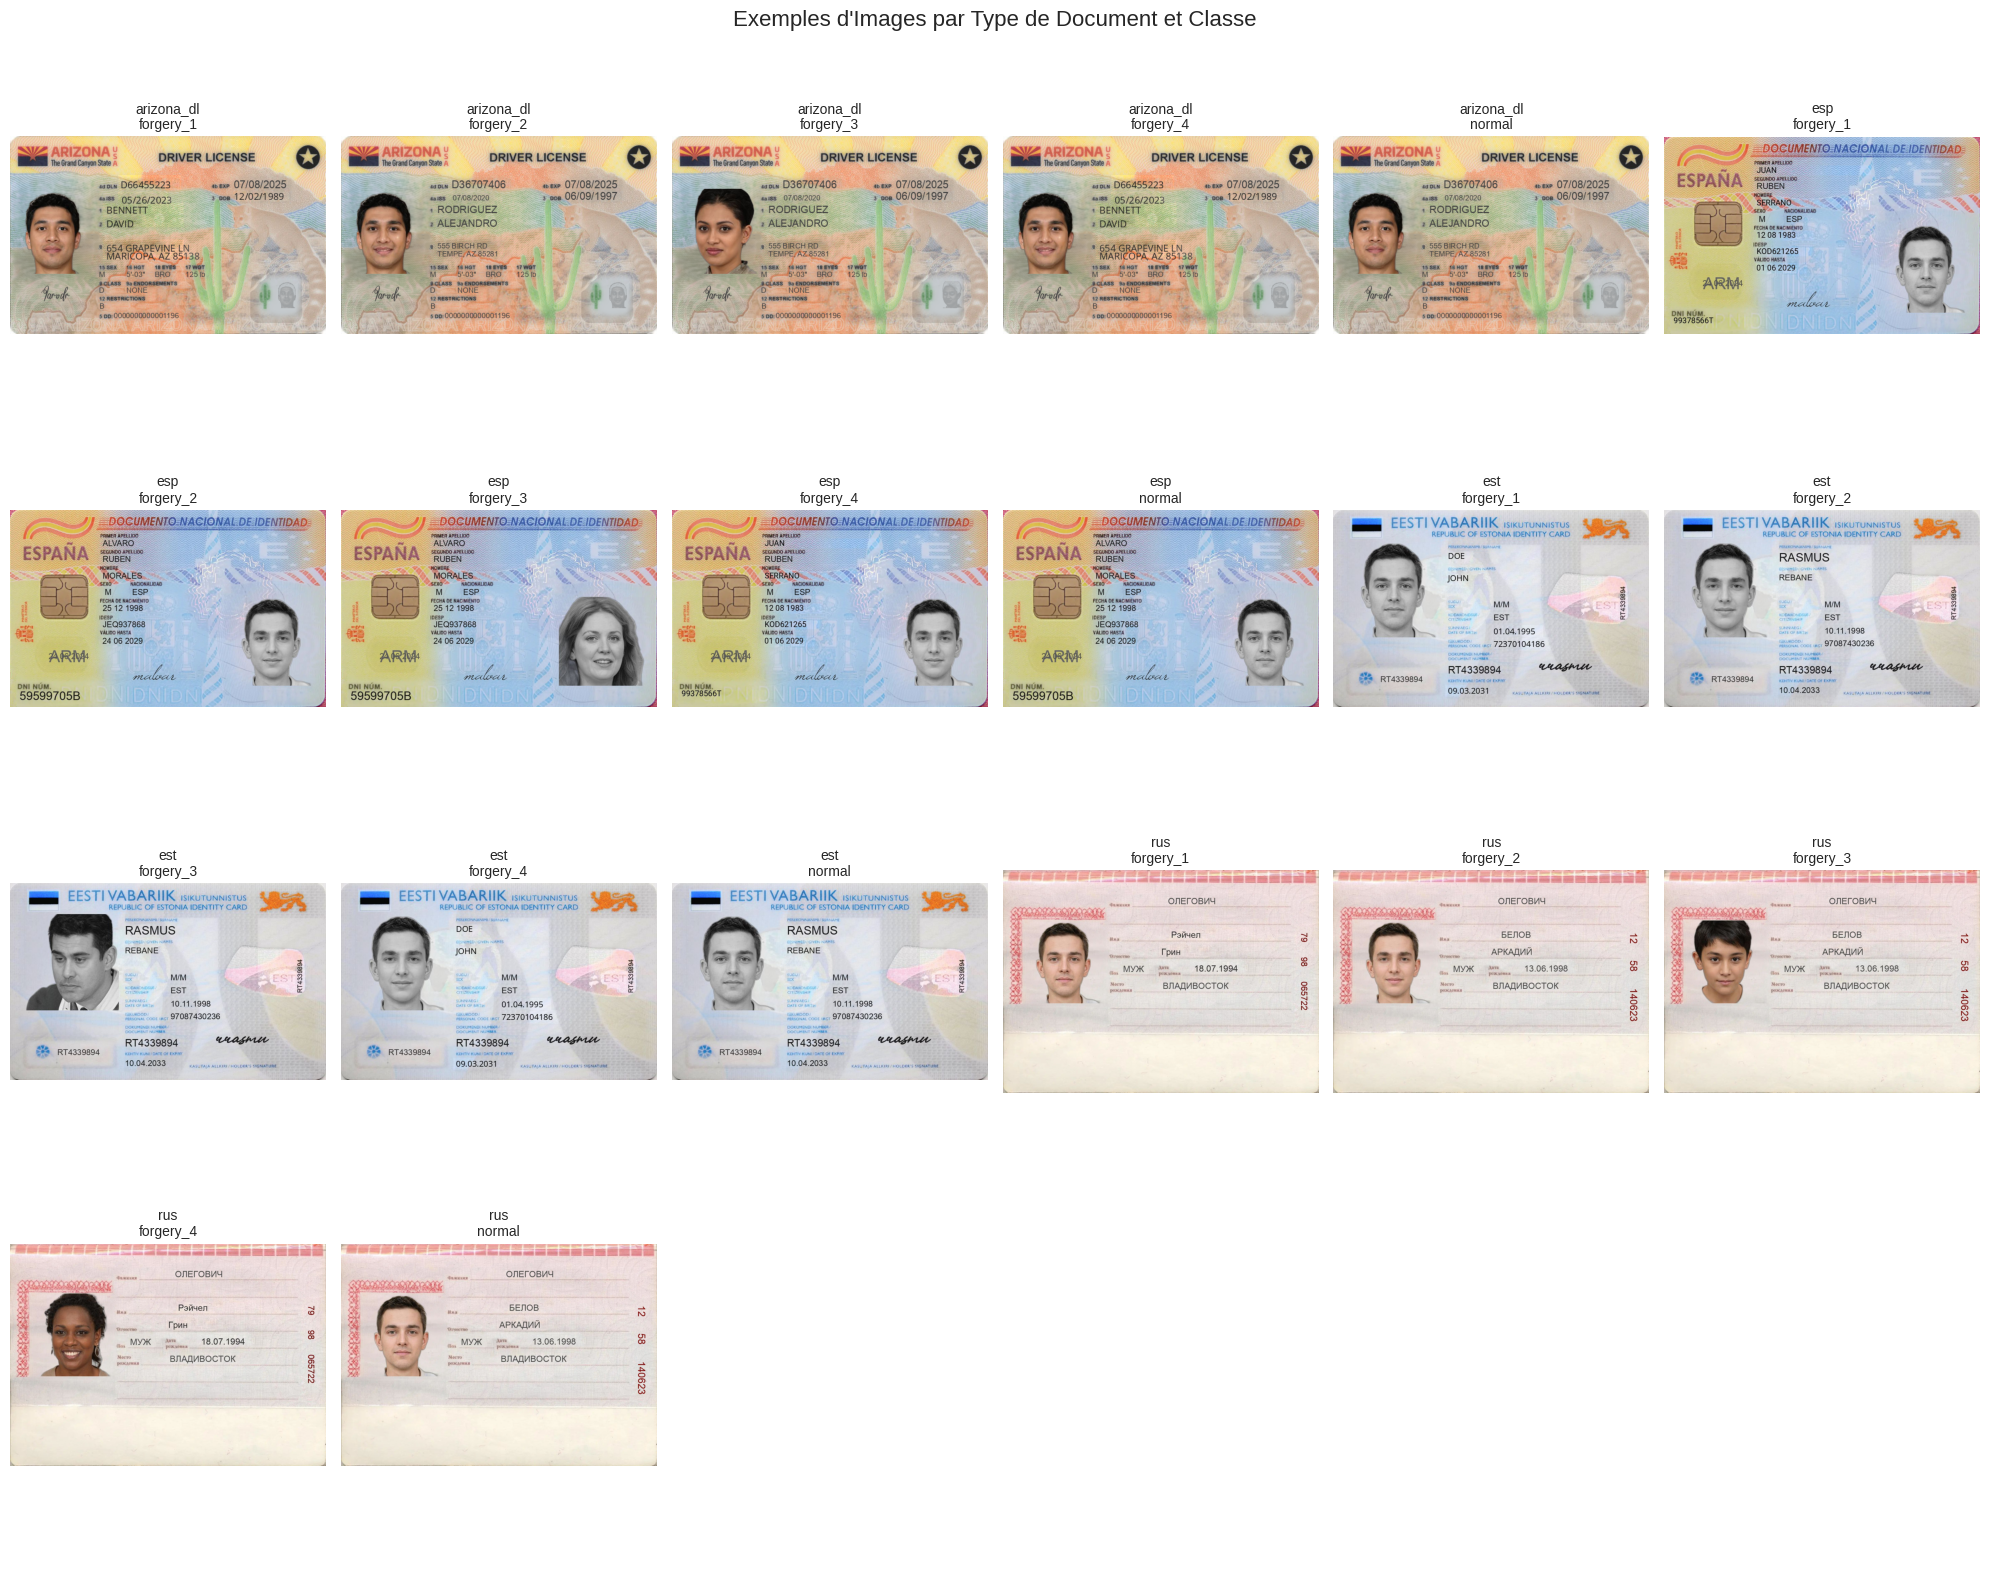


OBSERVATIONS POUR L'OCR:
1. Vérifier la netteté et lisibilité du texte dans chaque type
2. Observer les différences de qualité entre 'normal' et 'forgery_X'
3. Identifier les zones de texte importantes pour l'extraction OCR
4. Noter les variations de format et layout entre types de documents


In [44]:
if len(df_train) > 0:
    print("VISUALISATION D'EXEMPLES D'IMAGES")
    print("="*40)
    
    # Sélectionner des exemples représentatifs
    examples_per_type = 2
    examples_per_class = 1
    
    fig, axes = plt.subplots(4, 6, figsize=(20, 16))  # 4 types de documents x 6 classes max
    axes = axes.flatten()
    
    plot_idx = 0
    
    for doc_type in sorted(df_train['document_type'].unique()):
        print(f"\n--- Exemples pour {doc_type.upper()} ---")
        
        doc_data = df_train[df_train['document_type'] == doc_type]
        classes = sorted(doc_data['class_name'].unique())
        
        for class_name in classes:
            class_data = doc_data[doc_data['class_name'] == class_name]
            
            if len(class_data) > 0 and plot_idx < len(axes):
                # Prendre le premier exemple de cette classe
                example = class_data.iloc[0]
                
                try:
                    img = Image.open(example['file_path'])
                    
                    # Redimensionner pour l'affichage si nécessaire
                    if img.width > 800 or img.height > 600:
                        img.thumbnail((800, 600), Image.Resampling.LANCZOS)
                    
                    axes[plot_idx].imshow(img)
                    axes[plot_idx].set_title(f"{doc_type}\n{class_name}", fontsize=10)
                    axes[plot_idx].axis('off')
                    
                    print(f"   {class_name}: {example['filename']}")
                    
                except Exception as e:
                    axes[plot_idx].text(0.5, 0.5, f"Erreur\n{doc_type}\n{class_name}", 
                                       ha='center', va='center', transform=axes[plot_idx].transAxes)
                    axes[plot_idx].axis('off')
                    print(f"   {class_name}: Erreur - {e}")
                
                plot_idx += 1
    
    # Masquer les axes inutilisés
    for i in range(plot_idx, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Exemples d\'Images par Type de Document et Classe', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Analyser les différences visuelles observées
    print(f"\nOBSERVATIONS POUR L'OCR:")
    print("="*30)
    print("1. Vérifier la netteté et lisibilité du texte dans chaque type")
    print("2. Observer les différences de qualité entre 'normal' et 'forgery_X'")
    print("3. Identifier les zones de texte importantes pour l'extraction OCR")
    print("4. Noter les variations de format et layout entre types de documents")
    
else:
    print("Pas de données pour la visualisation")

## 7. Analyse de la Distribution des Classes

### Distribution par Type de Document et Classe

Cette analyse nous permet de comprendre :
1. **L'équilibre des classes** : Y a-t-il plus de documents authentiques que de falsifiés ?
2. **La représentation par type de document** : Certains types sont-ils sur ou sous-représentés ?
3. **Les types de falsification** : Quels sont les types de fraude les plus courants ?
4. **La qualité des données** : Y a-t-il des incohérences ou des problèmes ?

### Métriques Importantes

- **Ratio Authentique/Falsifié** : Important pour ajuster les métriques d'évaluation
- **Distribution par Document** : Arizona DL vs ESP vs EST vs RUS
- **Types de Falsification** : Forgery 1, 2, 3, 4 et leurs spécificités
- **Taille des Images** : Cohérence des dimensions pour le preprocessing

### Stratégie de Modélisation

Basé sur cette analyse, nous pourrons décider :
- **Approche de classification** : Binaire (authentique/falsifié) ou multi-classe
- **Techniques de balancement** : Si les classes sont déséquilibrées
- **Architecture de modèle** : CNN spécialisé pour chaque type de document ou modèle global
- **Métriques d'évaluation** : Précision, rappel, F1-score adaptés au déséquilibre

In [45]:
if len(df_train) > 0:
    # Analyse de la distribution globale
    print("ANALYSE DE LA DISTRIBUTION DES CLASSES")
    print("="*45)
    
    # Distribution par authenticité
    auth_dist = df_train['is_authentic'].value_counts()
    auth_pct = df_train['is_authentic'].value_counts(normalize=True) * 100
    
    print("Distribution Authentique vs Falsifié:")
    print(f"   Authentiques: {auth_dist[1]:,} images ({auth_pct[1]:.1f}%)")
    print(f"   Falsifiés: {auth_dist[0]:,} images ({auth_pct[0]:.1f}%)")
    
    # Distribution par type de document
    print(f"\nDistribution par Type de Document:")
    for doc_type in df_train['document_type'].unique():
        count = (df_train['document_type'] == doc_type).sum()
        percentage = count / len(df_train) * 100
        print(f"   {doc_type}: {count:,} images ({percentage:.1f}%)")
    
    # Distribution par classe détaillée
    print(f"\nDistribution par Classe:")
    class_dist = df_train['class_name'].value_counts()
    for class_name in class_dist.index:
        count = class_dist[class_name]
        percentage = count / len(df_train) * 100
        print(f"   {class_name}: {count:,} images ({percentage:.1f}%)")
        
else:
    print("Pas de données à analyser - dataset vide")

ANALYSE DE LA DISTRIBUTION DES CLASSES
Distribution Authentique vs Falsifié:
   Authentiques: 2,000 images (20.0%)
   Falsifiés: 8,000 images (80.0%)

Distribution par Type de Document:
   rus: 2,500 images (25.0%)
   est: 2,500 images (25.0%)
   arizona_dl: 2,500 images (25.0%)
   esp: 2,500 images (25.0%)

Distribution par Classe:
   forgery_1: 2,000 images (20.0%)
   normal: 2,000 images (20.0%)
   forgery_2: 2,000 images (20.0%)
   forgery_4: 2,000 images (20.0%)
   forgery_3: 2,000 images (20.0%)


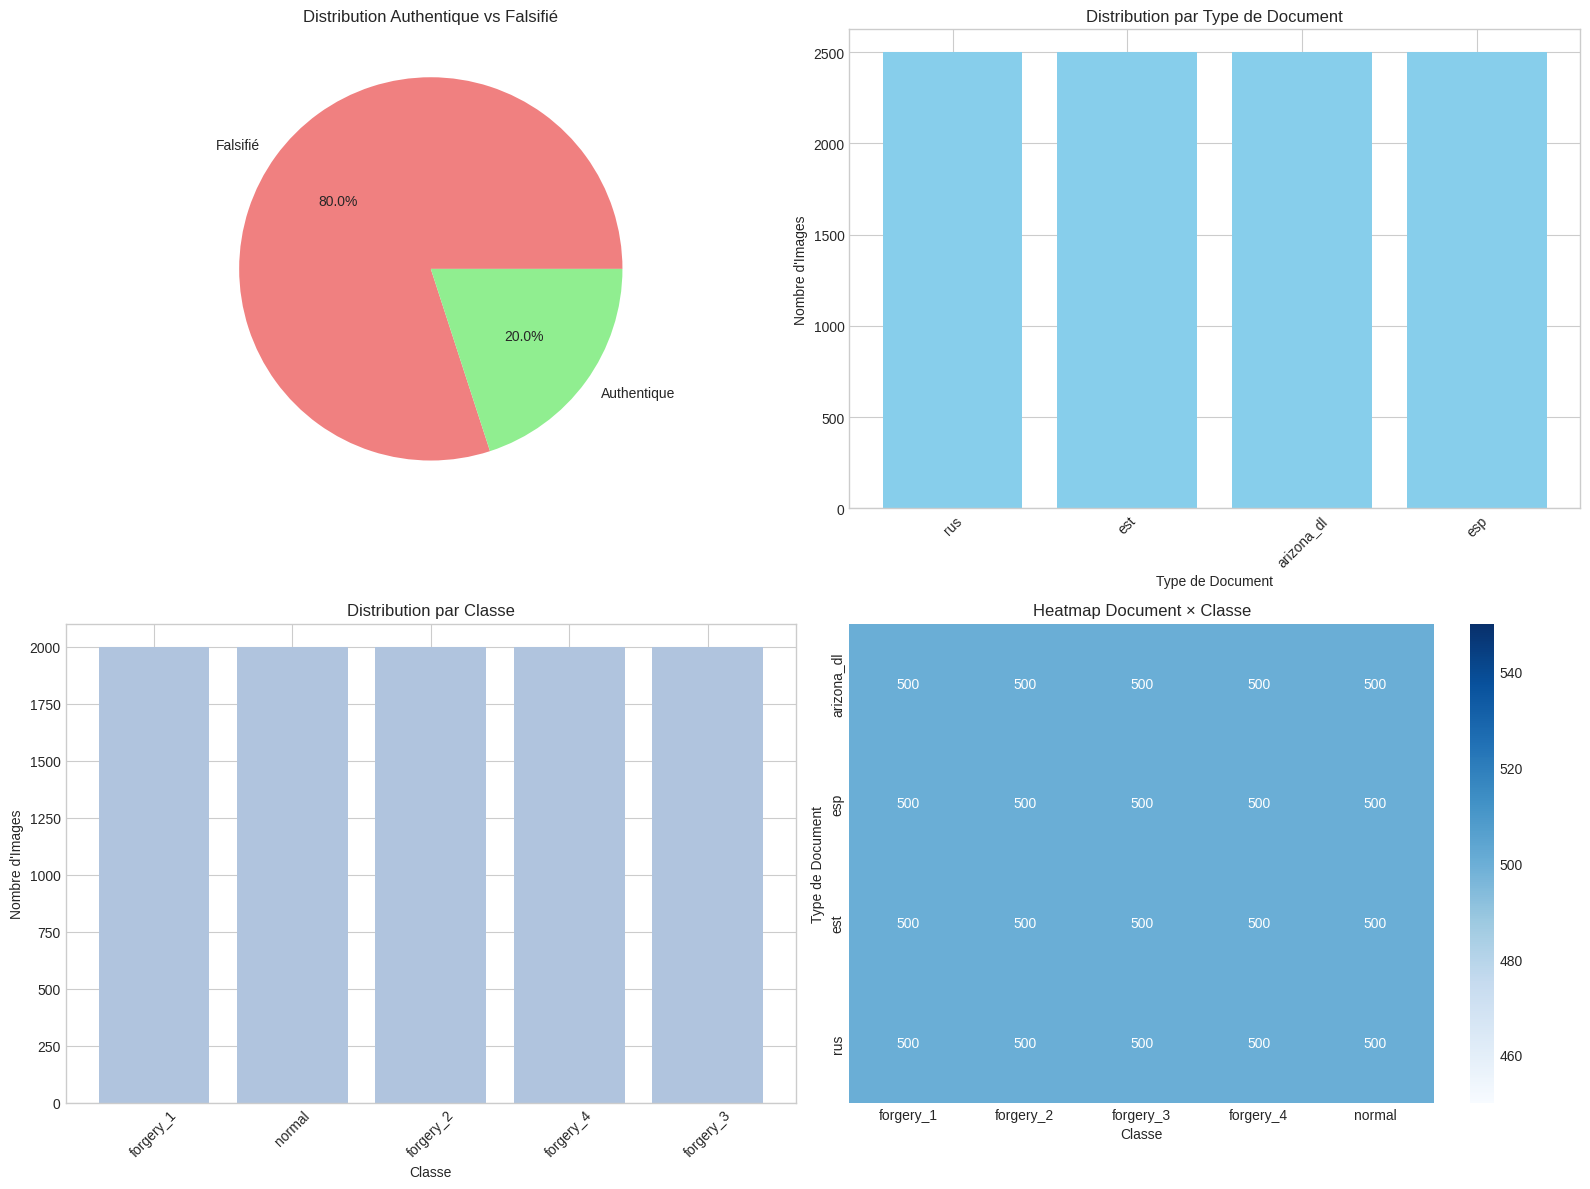

In [46]:
if len(df_train) > 0:
    # Visualisations de la distribution
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Distribution Authentique vs Falsifié
    auth_counts = df_train['is_authentic'].value_counts()
    labels = ['Falsifié', 'Authentique']
    colors = ['lightcoral', 'lightgreen']
    
    axes[0, 0].pie(auth_counts.values, labels=labels, autopct='%1.1f%%', colors=colors)
    axes[0, 0].set_title('Distribution Authentique vs Falsifié')
    
    # 2. Distribution par Type de Document
    doc_counts = df_train['document_type'].value_counts()
    axes[0, 1].bar(doc_counts.index, doc_counts.values, color='skyblue')
    axes[0, 1].set_title('Distribution par Type de Document')
    axes[0, 1].set_xlabel('Type de Document')
    axes[0, 1].set_ylabel('Nombre d\'Images')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Distribution par Classe
    class_counts = df_train['class_name'].value_counts()
    axes[1, 0].bar(class_counts.index, class_counts.values, color='lightsteelblue')
    axes[1, 0].set_title('Distribution par Classe')
    axes[1, 0].set_xlabel('Classe')
    axes[1, 0].set_ylabel('Nombre d\'Images')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Heatmap Type de Document vs Classe
    cross_tab = pd.crosstab(df_train['document_type'], df_train['class_name'])
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title('Heatmap Document × Classe')
    axes[1, 1].set_xlabel('Classe')
    axes[1, 1].set_ylabel('Type de Document')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Pas de données pour les visualisations")

In [47]:
if len(df_train) > 0:
    # Analyse détaillée par type de document
    print("ANALYSE DÉTAILLÉE PAR TYPE DE DOCUMENT")
    print("="*45)
    
    for doc_type in df_train['document_type'].unique():
        print(f"\n--- {doc_type.upper()} ---")
        
        # Filtrer les données pour ce type de document
        doc_data = df_train[df_train['document_type'] == doc_type]
        
        print(f"Total images: {len(doc_data)}")
        
        # Distribution des classes pour ce type de document
        class_dist = doc_data['class_name'].value_counts()
        print("Distribution des classes:")
        for class_name in class_dist.index:
            count = class_dist[class_name]
            percentage = count / len(doc_data) * 100
            print(f"   {class_name}: {count} images ({percentage:.1f}%)")
        
        # Ratio authentique/falsifié
        auth_count = (doc_data['is_authentic'] == 1).sum()
        fake_count = (doc_data['is_authentic'] == 0).sum()
        
        print(f"Authentiques: {auth_count} ({auth_count/len(doc_data)*100:.1f}%)")
        print(f"Falsifiés: {fake_count} ({fake_count/len(doc_data)*100:.1f}%)")
        
        # Types de falsification
        if fake_count > 0:
            forgery_types = doc_data[doc_data['is_authentic'] == 0]['forgery_type'].value_counts()
            print("Types de falsification:")
            for forgery_type in forgery_types.index:
                count = forgery_types[forgery_type]
                percentage = count / fake_count * 100
                print(f"   {forgery_type}: {count} images ({percentage:.1f}%)")
    
    # Analyse de l'équilibre global des classes
    print(f"\nANALYSE DE L'ÉQUILIBRE DES CLASSES")
    print("="*40)
    
    total_authentic = (df_train['is_authentic'] == 1).sum()
    total_fake = (df_train['is_authentic'] == 0).sum()
    balance_ratio = total_authentic / total_fake if total_fake > 0 else 0
    
    print(f"Ratio Authentique/Falsifié: {balance_ratio:.2f}")
    
    if balance_ratio > 1.5 or balance_ratio < 0.67:
        print("ATTENTION: Classes déséquilibrées détectées!")
        print("Recommandations:")
        print("   - Utiliser des métriques équilibrées (F1-score, AUC-ROC)")
        print("   - Considérer des techniques de rééchantillonnage")
        print("   - Ajuster les poids des classes dans le modèle")
    else:
        print("Classes relativement équilibrées")
    
    # Analyse de la distribution des fichiers
    print(f"\nSTATISTIQUES GÉNÉRALES")
    print("="*25)
    print(f"Types de documents uniques: {df_train['document_type'].nunique()}")
    print(f"Classes uniques: {df_train['class_name'].nunique()}")
    print(f"Total d'images: {len(df_train):,}")
    
    # Exemples de noms de fichiers pour comprendre la nomenclature
    print(f"\nExemples de nomenclature:")
    for doc_type in df_train['document_type'].unique()[:2]:
        examples = df_train[df_train['document_type'] == doc_type]['filename'].head(3).tolist()
        print(f"   {doc_type}: {examples}")
        
else:
    print("Pas de données pour l'analyse détaillée")

ANALYSE DÉTAILLÉE PAR TYPE DE DOCUMENT

--- RUS ---
Total images: 2500
Distribution des classes:
   forgery_1: 500 images (20.0%)
   normal: 500 images (20.0%)
   forgery_2: 500 images (20.0%)
   forgery_4: 500 images (20.0%)
   forgery_3: 500 images (20.0%)
Authentiques: 500 (20.0%)
Falsifiés: 2000 (80.0%)
Types de falsification:
   forgery_1: 500 images (25.0%)
   forgery_2: 500 images (25.0%)
   forgery_4: 500 images (25.0%)
   forgery_3: 500 images (25.0%)

--- EST ---
Total images: 2500
Distribution des classes:
   forgery_1: 500 images (20.0%)
   normal: 500 images (20.0%)
   forgery_2: 500 images (20.0%)
   forgery_4: 500 images (20.0%)
   forgery_3: 500 images (20.0%)
Authentiques: 500 (20.0%)
Falsifiés: 2000 (80.0%)
Types de falsification:
   forgery_1: 500 images (25.0%)
   forgery_2: 500 images (25.0%)
   forgery_4: 500 images (25.0%)
   forgery_3: 500 images (25.0%)

--- ARIZONA_DL ---
Total images: 2500
Distribution des classes:
   forgery_1: 500 images (20.0%)
   normal: 

## 8. Modélisation OCR et Classification

### Approche Hybride

Nous allons implémenter une **approche hybride** combinant :

1. **Classification de Fraude** : Détecter si un document est authentique ou falsifié
2. **Extraction OCR** : Extraire les champs textuels structurés
3. **Pipeline intégré** : Combiner les deux pour une prédiction complète

### Architecture Proposée

1. **Phase 1** : Modèle de classification CNN pour détecter la fraude
2. **Phase 2** : Extraction OCR conditionnelle (si authentique)
3. **Phase 3** : Post-processing et formatage des résultats

### Justification

- **Efficacité** : Pas besoin d'OCR sur les documents falsifiés
- **Précision** : OCR optimisé uniquement pour les documents authentiques
- **Flexibilité** : Permet d'ajuster la stratégie par type de document

In [ ]:
# Import des bibliothèques PyTorch spécialisées
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    import torchvision.transforms as transforms
    import torchvision.models as models
    
    pytorch_available = True
    print("PyTorch et torchvision importés avec succès")
except ImportError as e:
    print(f"Erreur import PyTorch: {e}")
    print("Installation nécessaire: pip install torch torchvision")
    pytorch_available = False

if pytorch_available:
    
    class DocumentDataset(Dataset):
        """
        Dataset PyTorch pour la classification de documents
        """
        def __init__(self, dataframe, transform=None, target_column='is_authentic'):
            """
            Args:
                dataframe: DataFrame avec colonnes 'file_path' et target_column
                transform: Transformations à appliquer aux images
                target_column: Colonne cible ('is_authentic' pour classification binaire)
            """
            self.dataframe = dataframe.reset_index(drop=True)
            self.transform = transform
            self.target_column = target_column
            
        def __len__(self):
            return len(self.dataframe)
        
        def __getitem__(self, idx):
            # Récupérer le chemin de l'image et le label
            img_path = self.dataframe.iloc[idx]['file_path']
            target = self.dataframe.iloc[idx][self.target_column]
            
            # Charger l'image
            try:
                image = Image.open(img_path).convert('RGB')
                
                # Appliquer les transformations
                if self.transform:
                    image = self.transform(image)
                    
                return image, torch.tensor(target, dtype=torch.long)
                
            except Exception as e:
                print(f"Erreur chargement image {img_path}: {e}")
                # Retourner une image vide en cas d'erreur
                dummy_image = torch.zeros(3, 224, 224)
                return dummy_image, torch.tensor(target, dtype=torch.long)
    
    print("Classe DocumentDataset définie")
    
    # Définir les transformations
    # Transformations pour l'entraînement (avec augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Taille standard pour les modèles CNN
        transforms.RandomHorizontalFlip(p=0.3),  # Augmentation légère
        transforms.RandomRotation(degrees=2),    # Rotation très légère
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet
    ])
    
    # Transformations pour la validation (sans augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    print("Transformations définies")
    
else:
    print("PyTorch non disponible - passage en mode dégradé")

### 8.1 Dataset PyTorch pour la Classification

Création des datasets PyTorch avec transformations adaptées pour la classification de documents.

In [ ]:
if pytorch_available and len(df_train) > 0:
    print("CRÉATION DES DATASETS ET DATALOADERS")
    print("="*45)
    
    # Créer les datasets
    train_dataset = DocumentDataset(X_train, transform=train_transform)
    val_dataset = DocumentDataset(X_val, transform=val_transform)
    
    print(f"Datasets créés:")
    print(f"   Train: {len(train_dataset)} images")
    print(f"   Validation: {len(val_dataset)} images")
    
    # Configuration des DataLoaders
    batch_size = 32  # Ajustable selon la mémoire GPU
    num_workers = 2  # Ajustable selon le CPU
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True if device.type == 'cuda' else False
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True if device.type == 'cuda' else False
    )
    
    print(f"DataLoaders configurés:")
    print(f"   Batch size: {batch_size}")
    print(f"   Num workers: {num_workers}")
    print(f"   Device: {device}")
    print(f"   Pin memory: {device.type == 'cuda'}")
    
    # Test de chargement d'un batch
    try:
        sample_batch = next(iter(train_loader))
        images, labels = sample_batch
        print(f"\nTest batch:")
        print(f"   Images shape: {images.shape}")
        print(f"   Labels shape: {labels.shape}")
        print(f"   Labels distribution: {torch.bincount(labels)}")
        
    except Exception as e:
        print(f"Erreur test batch: {e}")
    
else:
    print("Impossible de créer les DataLoaders - PyTorch non disponible ou pas de données")

### 8.2 Création des DataLoaders

Configuration des DataLoaders avec les paramètres optimaux pour l'entraînement.

### 8.3 Modèle de Classification

Architecture CNN basée sur ResNet pour la classification authentique/falsifié.

In [ ]:
if pytorch_available:
    
    class FraudDetectionModel(nn.Module):
        """
        Modèle CNN pour la détection de fraude documentaire
        Basé sur ResNet50 avec fine-tuning
        """
        def __init__(self, num_classes=2, pretrained=True):
            super(FraudDetectionModel, self).__init__()
            
            # Backbone ResNet50 pré-entraîné
            self.backbone = models.resnet50(pretrained=pretrained)
            
            # Récupérer le nombre de features de la dernière couche
            num_features = self.backbone.fc.in_features
            
            # Remplacer la couche de classification
            self.backbone.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)
            )
            
        def forward(self, x):
            return self.backbone(x)
    
    # Initialiser le modèle
    print("INITIALISATION DU MODÈLE DE CLASSIFICATION")
    print("="*45)
    
    model = FraudDetectionModel(num_classes=2, pretrained=True)
    model = model.to(device)
    
    # Compter les paramètres
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Modèle initialisé:")
    print(f"   Architecture: ResNet50 + Custom Head")
    print(f"   Classes: 2 (Authentique/Falsifié)")
    print(f"   Paramètres totaux: {total_params:,}")
    print(f"   Paramètres entraînables: {trainable_params:,}")
    print(f"   Device: {device}")
    
    # Configuration de l'entraînement
    # Fonction de perte avec pondération pour gérer le déséquilibre
    class_counts = torch.bincount(y_train.values)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum() * len(class_weights)
    
    print(f"\nGestion du déséquilibre des classes:")
    print(f"   Classe 0 (Falsifié): {class_counts[0]} échantillons, poids: {class_weights[0]:.3f}")
    print(f"   Classe 1 (Authentique): {class_counts[1]} échantillons, poids: {class_weights[1]:.3f}")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    # Optimiseur avec learning rate adaptatif
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Scheduler pour réduire le learning rate
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5, verbose=True
    )
    
    print(f"Configuration d'entraînement:")
    print(f"   Critère: CrossEntropyLoss (pondéré)")
    print(f"   Optimiseur: Adam (lr=0.001, weight_decay=1e-4)")
    print(f"   Scheduler: ReduceLROnPlateau")
    
else:
    print("PyTorch non disponible - modèle non initialisé")

### 8.4 Fonction d'Entraînement

Implémentation de la boucle d'entraînement avec validation et métriques.

In [ ]:
if pytorch_available:
    
    def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                    num_epochs=10, device='cpu'):
        """
        Fonction d'entraînement du modèle avec validation
        """
        print(f"DÉMARRAGE DE L'ENTRAÎNEMENT")
        print("="*30)
        print(f"Epochs: {num_epochs}")
        print(f"Device: {device}")
        print(f"Train batches: {len(train_loader)}")
        print(f"Val batches: {len(val_loader)}")
        
        # Historique des métriques
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        best_val_acc = 0.0
        best_model_state = None
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 20)
            
            # Phase d'entraînement
            model.train()
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                # Statistiques
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
                
                # Affichage du progrès
                if batch_idx % 10 == 0:
                    print(f"  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
            
            # Métriques d'entraînement
            train_loss = running_loss / total_samples
            train_acc = running_corrects.double() / total_samples
            
            # Phase de validation
            model.eval()
            val_running_loss = 0.0
            val_running_corrects = 0
            val_total_samples = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    val_running_loss += loss.item() * inputs.size(0)
                    val_running_corrects += torch.sum(preds == labels.data)
                    val_total_samples += inputs.size(0)
            
            # Métriques de validation
            val_loss = val_running_loss / val_total_samples
            val_acc = val_running_corrects.double() / val_total_samples
            
            # Sauvegarder le meilleur modèle
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()
            
            # Scheduler
            scheduler.step(val_loss)
            
            # Enregistrer l'historique
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc.item())
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc.item())
            
            # Affichage des résultats
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            print(f"Best Val Acc: {best_val_acc:.4f}")
        
        # Charger le meilleur modèle
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f"\nMeilleur modèle chargé (Val Acc: {best_val_acc:.4f})")
        
        return model, history
    
    print("Fonction d'entraînement définie")
    
else:
    print("PyTorch non disponible - fonction d'entraînement non définie")

### 8.5 Entraînement du Modèle

Entraînement rapide pour validation du pipeline (3 epochs). Pour la soumission finale, augmenter le nombre d'epochs.

In [ ]:
if pytorch_available and 'model' in locals() and 'train_loader' in locals():
    
    # Configuration pour entraînement rapide (test du pipeline)
    num_epochs = 3  # Augmenter à 15-20 pour la soumission finale
    
    print("LANCEMENT DE L'ENTRAÎNEMENT")
    print("="*35)
    print(f"ATTENTION: Entraînement rapide avec {num_epochs} epochs")
    print("Pour la soumission finale, augmenter num_epochs à 15-20")
    
    # Lancer l'entraînement
    try:
        trained_model, training_history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=num_epochs,
            device=device
        )
        
        print("\nEntraînement terminé avec succès!")
        
        # Sauvegarder le modèle
        model_save_path = SUBMISSIONS_DIR / 'fraud_detection_model.pth'
        SUBMISSIONS_DIR.mkdir(exist_ok=True)
        
        torch.save({
            'model_state_dict': trained_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': training_history,
            'num_epochs': num_epochs,
            'device': str(device)
        }, model_save_path)
        
        print(f"Modèle sauvegardé: {model_save_path}")
        
    except Exception as e:
        print(f"Erreur pendant l'entraînement: {e}")
        print("Vérifier la disponibilité de PyTorch et des données")
        
else:
    print("Conditions non remplies pour l'entraînement:")
    print(f"   PyTorch disponible: {pytorch_available}")
    print(f"   Modèle défini: {'model' in locals()}")
    print(f"   DataLoader défini: {'train_loader' in locals()}")
    print("\nPour l'entraînement, s'assurer que toutes les cellules précédentes sont exécutées")

## 9. Extraction OCR et Prédiction

### Pipeline d'Inférence Complet

1. **Classification** : Détecter si le document est authentique ou falsifié
2. **OCR conditionnel** : Si authentique, extraire les champs textuels
3. **Post-processing** : Nettoyer et structurer les résultats
4. **Formatage** : Générer la soumission au format requis

### Stratégie OCR

- **EasyOCR** : Pour la détection et reconnaissance de texte
- **Regex patterns** : Pour l'extraction de champs spécifiques
- **Validation** : Vérification de cohérence des données extraites

### 9.1 Fonctions OCR

Implémentation des fonctions d'extraction OCR avec patterns spécialisés par type de document.

In [ ]:
# Configuration et test des outils OCR
import re
from datetime import datetime

# Vérifier EasyOCR
try:
    import easyocr
    reader = easyocr.Reader(['en', 'es', 'et', 'ru'], gpu=device.type == 'cuda')
    ocr_reader_available = True
    print("EasyOCR initialisé avec succès")
    print(f"Langues supportées: anglais, espagnol, estonien, russe")
    print(f"GPU activé: {device.type == 'cuda'}")
except ImportError:
    print("EasyOCR non disponible - installation nécessaire: pip install easyocr")
    ocr_reader_available = False
except Exception as e:
    print(f"Erreur initialisation EasyOCR: {e}")
    ocr_reader_available = False

def extract_text_easyocr(image_path, confidence_threshold=0.5):
    """
    Extrait le texte d'une image avec EasyOCR
    """
    if not ocr_reader_available:
        return []
    
    try:
        results = reader.readtext(str(image_path))
        
        # Filtrer par confidence et nettoyer
        extracted_texts = []
        for (bbox, text, confidence) in results:
            if confidence >= confidence_threshold:
                cleaned_text = text.strip()
                if len(cleaned_text) > 1:  # Ignorer les caractères isolés
                    extracted_texts.append({
                        'text': cleaned_text,
                        'confidence': confidence,
                        'bbox': bbox
                    })
        
        return extracted_texts
    
    except Exception as e:
        print(f"Erreur OCR pour {image_path}: {e}")
        return []

def extract_document_fields(text_results, document_type):
    """
    Extrait les champs spécifiques selon le type de document
    """
    # Combiner tous les textes extraits
    all_text = " ".join([item['text'] for item in text_results])
    
    # Patterns regex pour différents champs
    patterns = {
        'surname': [
            r'(?:SURNAME|APELLIDO|NIMI|ФАМИЛИЯ)[:\s]*([A-ZÀ-ÿА-Я\s]+)',
            r'([A-ZÀ-ÿА-Я]{2,})\s+[A-ZÀ-ÿА-Я]',  # Pattern générique nom/prénom
        ],
        'given_name': [
            r'(?:NAME|GIVEN|NOMBRE|EESNIMI|ИМЯ)[:\s]*([A-ZÀ-ÿА-Я\s]+)',
            r'[A-ZÀ-ÿА-Я]{2,}\s+([A-ZÀ-ÿА-Я]+)',  # Pattern générique prénom après nom
        ],
        'birthday': [
            r'(\d{1,2}[./]\d{1,2}[./]\d{4})',  # DD/MM/YYYY ou DD.MM.YYYY
            r'(\d{4}[./]\d{1,2}[./]\d{1,2})',  # YYYY/MM/DD
            r'(\d{2}\s\d{2}\s\d{4})',          # DD MM YYYY
        ],
        'card_num': [
            r'(?:ID|CARD|NUM)[:\s]*([A-Z0-9]{6,15})',
            r'([A-Z]{2,3}\d{6,10})',
            r'(\d{8,12}[A-Z]?)',
        ],
        'personal_num': [
            r'(\d{11,14})',  # Numéros personnels longs
        ],
        'country_code': [
            r'(EST|ESP|USA|RUS)',
            r'(ESTONIA|ESPAÑA|RUSSIA)',
        ]
    }
    
    extracted_fields = {}
    
    for field, field_patterns in patterns.items():
        for pattern in field_patterns:
            match = re.search(pattern, all_text, re.IGNORECASE)
            if match:
                extracted_fields[field] = match.group(1).strip()
                break
    
    # Post-processing spécifique par type de document
    if document_type == 'arizona_dl':
        extracted_fields['country_code'] = 'USA'
    elif document_type == 'esp':
        extracted_fields['country_code'] = 'ESP'
    elif document_type == 'est':
        extracted_fields['country_code'] = 'EST'
    elif document_type == 'rus':
        extracted_fields['country_code'] = 'RUS'
    
    return extracted_fields

print("Fonctions OCR définies")

# Test sur un échantillon si disponible
if ocr_reader_available and len(df_train) > 0:
    # Tester sur une image authentique
    authentic_samples = df_train[df_train['is_authentic'] == 1].head(1)
    
    if len(authentic_samples) > 0:
        test_image = authentic_samples.iloc[0]
        print(f"\nTest OCR sur: {test_image['filename']}")
        print(f"Type de document: {test_image['document_type']}")
        
        try:
            # Extraction du texte
            text_results = extract_text_easyocr(test_image['file_path'])
            print(f"Textes extraits: {len(text_results)}")
            
            # Afficher quelques résultats
            for i, result in enumerate(text_results[:5]):
                print(f"  {i+1}. '{result['text']}' (conf: {result['confidence']:.3f})")
            
            # Extraction des champs
            fields = extract_document_fields(text_results, test_image['document_type'])
            print(f"\nChamps extraits:")
            for field, value in fields.items():
                print(f"   {field}: {value}")
                
        except Exception as e:
            print(f"Erreur test OCR: {e}")
            
else:
    print("Test OCR non effectué - EasyOCR non disponible ou pas de données")

### 9.2 Pipeline de Prédiction Complet

Fonction intégrée qui combine classification + OCR pour générer les prédictions finales.

In [ ]:
def predict_document(image_path, document_type, model, transform, device, confidence_threshold=0.8):
    """
    Pipeline complet de prédiction : classification + OCR
    """
    prediction_result = {
        'is_authentic': False,
        'confidence': 0.0,
        'extracted_fields': {}
    }
    
    try:
        # 1. Classification de fraude
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        model.eval()
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            pred_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][pred_class].item()
        
        prediction_result['confidence'] = confidence
        
        # 2. Si authentique ET haute confiance -> OCR
        if pred_class == 1 and confidence >= confidence_threshold:
            prediction_result['is_authentic'] = True
            
            if ocr_reader_available:
                # Extraction OCR
                text_results = extract_text_easyocr(image_path)
                fields = extract_document_fields(text_results, document_type)
                prediction_result['extracted_fields'] = fields
            else:
                # Fallback si OCR non disponible
                prediction_result['extracted_fields'] = {
                    'country_code': document_type.upper()[:3],
                    'surname': 'UNKNOWN',
                    'given_name': 'UNKNOWN',
                    'birthday': '01.01.2000'
                }
        else:
            # Document falsifié - pas d'OCR
            prediction_result['is_authentic'] = False
            prediction_result['extracted_fields'] = {
                'fraud_detected': True,
                'fraud_confidence': confidence
            }
    
    except Exception as e:
        print(f"Erreur prédiction {image_path}: {e}")
    
    return prediction_result

def generate_submission_format(predictions_list, output_path):
    """
    Génère le fichier de soumission au format requis
    """
    results = []
    
    for pred in predictions_list:
        if pred['is_authentic']:
            # Document authentique - format OCR
            result = pred['extracted_fields'].copy()
        else:
            # Document falsifié - signaler la fraude
            result = {
                'fraud_detected': True,
                'confidence': pred['confidence']
            }
        
        results.append(result)
    
    # Sauvegarder en JSON
    import json
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    
    print(f"Soumission sauvegardée: {output_path}")
    return results

print("Pipeline de prédiction défini")

# Démonstration sur quelques échantillons
if pytorch_available and 'model' in locals() and len(df_train) > 0:
    print("\nTEST DU PIPELINE SUR ÉCHANTILLONS")
    print("="*40)
    
    # Tester sur 3 échantillons (1 authentique, 2 falsifiés)
    test_samples = []
    
    # 1 échantillon authentique
    authentic = df_train[df_train['is_authentic'] == 1].head(1)
    if len(authentic) > 0:
        test_samples.append(authentic.iloc[0])
    
    # 2 échantillons falsifiés
    fake = df_train[df_train['is_authentic'] == 0].head(2)
    test_samples.extend([fake.iloc[i] for i in range(len(fake))])
    
    predictions = []
    
    for i, sample in enumerate(test_samples):
        print(f"\nTest {i+1}: {sample['filename']}")
        print(f"Type: {sample['document_type']}, Réel: {'Authentique' if sample['is_authentic'] else 'Falsifié'}")
        
        pred = predict_document(
            image_path=sample['file_path'],
            document_type=sample['document_type'],
            model=model,
            transform=val_transform,
            device=device
        )
        
        predictions.append(pred)
        
        print(f"Prédiction: {'Authentique' if pred['is_authentic'] else 'Falsifié'}")
        print(f"Confiance: {pred['confidence']:.3f}")
        
        if pred['extracted_fields']:
            print("Champs extraits:")
            for field, value in pred['extracted_fields'].items():
                print(f"   {field}: {value}")
    
    # Générer un exemple de soumission
    submission_path = SUBMISSIONS_DIR / 'example_submission.json'
    generate_submission_format(predictions, submission_path)
    
else:
    print("Test du pipeline non effectué - conditions non remplies")